In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from celldreamer.paths import DATA_DIR

from pathlib import Path

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [10]:
raw_dataset_path = DATA_DIR / "raw" / "tabula_muris.h5ad"

adata = sc.read(
    raw_dataset_path,
    backup_url="https://figshare.com/ndownloader/files/23938934",
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [11]:
adata.layers["X_counts"] = adata.X.copy()

In [13]:
adata 

AnnData object with n_obs × n_vars = 245389 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
    layers: 'X_counts'

In [12]:
sc.pp.filter_genes(adata, min_cells=5)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


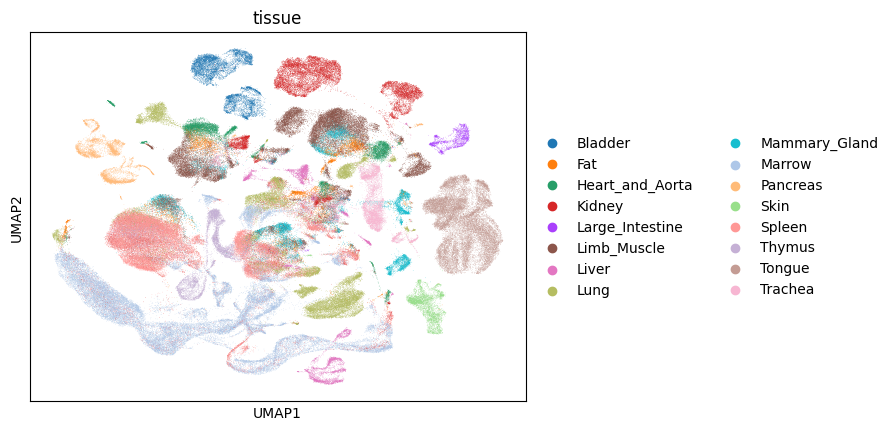

In [7]:
sc.pl.umap(adata, color="tissue")

## Train Test split 

In [8]:
# Generate random indices for train and test sets
total_samples = adata.n_obs
train_frac = 0.8
train_size = int(total_samples * train_frac)
train_indices = np.random.choice(total_samples, size=train_size, replace=False)
test_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Separate data into train and test sets by indexing the Anndata object
train_adata = adata[train_indices, :]
test_adata = adata[test_indices, :]

In [9]:
train_adata

View of AnnData object with n_obs × n_vars = 196311 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [10]:
test_adata

View of AnnData object with n_obs × n_vars = 49078 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

In [11]:
adata

AnnData object with n_obs × n_vars = 245389 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'distances', 'connectivities'

# Save files

In [12]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris.h5ad")

In [13]:
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_train.h5ad")

In [14]:
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_test.h5ad")

## Run highly variable gene selection

In [2]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris.h5ad")
train_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_train.h5ad")
test_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_test.h5ad")

In [3]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=False,
)

In [4]:
train_adata.var = adata.var
test_adata.var = adata.var

In [5]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris.h5ad")
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_test.h5ad")
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris_train.h5ad")

# Check dataset

In [4]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris.h5ad")

In [7]:
adata.obs.columns

Index(['age', 'cell', 'cell_ontology_class', 'cell_ontology_id',
       'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue',
       'tissue', 'tissue_free_annotation'],
      dtype='object')

In [8]:
adata.obs.free_annotation

index
AAACCTGCAGGGTACA-1-0-0-0                          filiform
AAACCTGCAGTAAGCG-1-0-0-0                        suprabasal
AAACCTGTCATTATCC-1-0-0-0                        suprabasal
AAACGGGGTACAGTGG-1-0-0-0        suprabasal differentiating
AAACGGGGTCTTCTCG-1-0-0-0        suprabasal differentiating
                                           ...            
10X_P8_15_TTTGTCAGTACATGTC-1                           nan
10X_P8_15_TTTGTCAGTGCGCTTG-1                           nan
10X_P8_15_TTTGTCAGTTGTCGCG-1                           nan
10X_P8_15_TTTGTCATCGGCTTGG-1                           nan
10X_P8_15_TTTGTCATCTTGTTTG-1                           nan
Name: free_annotation, Length: 245389, dtype: category
Categories (126, object): ['Adventitial Fibroblast', 'Airway Smooth Muscle', 'Alveolar Epithelial Type 2', 'Alveolar Fibroblast', ..., 'suprabasal', 'suprabasal differentiating', 'suprabasal interpapillary', 'unknown']

(array([68., 23., 18.,  1.,  2.,  1.,  0.,  3.,  0.,  1.,  1.,  2.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([2.00000000e+00, 1.02593333e+03, 2.04986667e+03, 3.07380000e+03,
        4.09773333e+03, 5.12166667e+03, 6.14560000e+03, 7.16953333e+03,
        8.19346667e+03, 9.21740000e+03, 1.02413333e+04, 1.12652667e+04,
        1.22892000e+04, 1.33131333e+04, 1.43370667e+04, 1.53610000e+04,
        1.63849333e+04, 1.74088667e+04, 1.84328000e+04, 1.94567333e+04,
        2.04806667e+04, 2.15046000e+04, 2.25285333e+04, 2.35524667e+04,
        2.45764000e+04, 2.56003333e+04, 2.66242667e+04, 2.76482000e+04,
        2.86721333e+04, 2.96960667e+04, 3.07200000e+04]),
 <BarContainer object of 30 artists>)

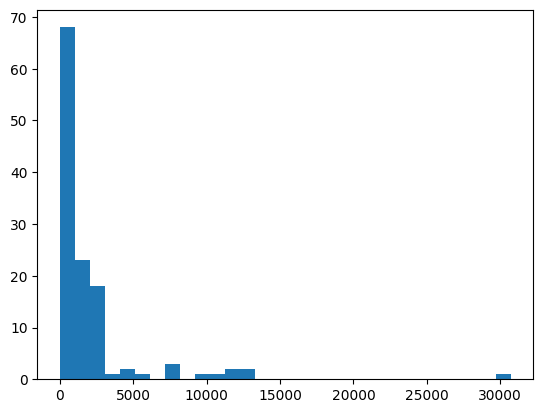

In [13]:
plt.hist(adata.obs.cell_ontology_class.value_counts(), bins=30)

In [2]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "tabula_muris" / "tabula_muris.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 245389 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs.cell_ontology_class

index
AAACCTGCAGGGTACA-1-0-0-0                                          keratinocyte
AAACCTGCAGTAAGCG-1-0-0-0                                          keratinocyte
AAACCTGTCATTATCC-1-0-0-0                                          keratinocyte
AAACGGGGTACAGTGG-1-0-0-0                                          keratinocyte
AAACGGGGTCTTCTCG-1-0-0-0                                          keratinocyte
                                                     ...                      
10X_P8_15_TTTGTCAGTACATGTC-1    basal epithelial cell of tracheobronchial tree
10X_P8_15_TTTGTCAGTGCGCTTG-1                       mesenchymal progenitor cell
10X_P8_15_TTTGTCAGTTGTCGCG-1                                  endothelial cell
10X_P8_15_TTTGTCATCGGCTTGG-1                                  endothelial cell
10X_P8_15_TTTGTCATCTTGTTTG-1                                       chondrocyte
Name: cell_ontology_class, Length: 245389, dtype: category
Categories (123, object): ['B cell', 'CD4-positive, alpha-beta T c